<a href="https://colab.research.google.com/github/lalit527/DL/blob/master/Dog_Breed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install fastai==0.7.0
import sys
!{sys.executable} -m pip install torchtext==0.2.3
# !curl http://files.fast.ai/data/dogscats.zip --output sample_data/dogscats.zip
  # !unzip sample_data/dogscats.zip  

In [ ]:
!pip install kaggle
import os
os.environ['KAGGLE_USERNAME'] = "lalit527"
os.environ['KAGGLE_KEY'] = ""
!kaggle competitions download -c dog-breed-identification
!unzip train.zip 
!unzip test.zip 
!unzip labels.csv.zip 

In [ ]:
!mkdir -p data/dogbreed

In [ ]:
!mv test data/dogbreed/test
!mv train data/dogbreed/train
!mv labels.csv data/dogbreed/

In [6]:
!ls data/dogbreed

labels.csv  test  train


In [32]:
!wget 'http://files.fast.ai/models/weights.tgz' 

--2019-02-16 16:18:23--  http://files.fast.ai/models/weights.tgz
Resolving files.fast.ai (files.fast.ai)... 67.205.15.147
Connecting to files.fast.ai (files.fast.ai)|67.205.15.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1195411318 (1.1G) [text/plain]
Saving to: ‘weights.tgz’

weights.tgz         100%[===================>]   1.11G   100MB/s    in 11s     

2019-02-16 16:18:34 (99.8 MB/s) - ‘weights.tgz’ saved [1195411318/1195411318]



In [35]:
!tar -xvzf weights.tgz

weights/
weights/wrn_50_2f.pth
weights/resnext_101_32x4d.pth
weights/resnext_101_64x4d.pth
weights/inceptionresnetv2-d579a627.pth
weights/inceptionv4-97ef9c30.pth
weights/resnext_50_32x4d.pth


In [36]:
!ls

data		sample_data		   test.zip   weights
labels.csv.zip	sample_submission.csv.zip  train.zip  weights.tgz


In [ ]:
!mv weights /usr/local/lib/python3.6/dist-packages/fastai/

# Importing the Libraries

In [1]:
import fastai
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [ ]:
PATH = "data/dogbreed/"
sz=224
arch=resnext101_64
bs=16

In [ ]:
label_csv = f'{PATH}labels.csv'
n = len(list(open(label_csv))) - 1
val_idxs = get_cv_idxs(n)

- n = len(list(open(label_csv)))-1 : Open CSV file, create a list of rows, then take the length. -1 because the first row is a header. Hence n is the number of images we have.
- val_idxs = get_cv_idxs(n) : “get cross validation indexes” — this will return, by default, random 20% of the rows (indexes to be precise) to use as a validation set.

In [10]:
n

10222

In [11]:
val_idxs

array([2882, 4514, 7717, ..., 8922, 6774,   37])

In [ ]:
### 2 Initial Exploration

In [13]:
!ls {PATH}

labels.csv  test  train


### it has a CSV file with the correct labels. We will read CSV file with Pandas

In [ ]:
label_df = pd.read_csv(label_csv)

In [20]:
label_df.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [16]:
label_df.pivot_table(index='breed', aggfunc=len).sort_values('id', ascending=False)

id
breed                              
scottish_deerhound              126
maltese_dog                     117
afghan_hound                    116
entlebucher                     115
bernese_mountain_dog            114
shih-tzu                        112
great_pyrenees                  111
pomeranian                      111
basenji                         110
samoyed                         109
airedale                        107
tibetan_terrier                 107
leonberg                        106
cairn                           106
beagle                          105
japanese_spaniel                105
australian_terrier              102
blenheim_spaniel                102
miniature_pinscher              102
irish_wolfhound                 101
lakeland_terrier                 99
saluki                           99
papillon                         96
whippet                          95
siberian_husky                   95
norwegian_elkhound               95
pug                              94
chow                             93
italian_greyhound                92
pembroke                         92
...                             ...
german_short-haired_pointer      75
boxer                            75
bull_mastiff                     75
borzoi                           75
pekinese                         75
cocker_spaniel                   74
american_staffordshire_terrier   74
doberman                         74
brittany_spaniel                 73
malinois                         73
standard_schnauzer               72
flat-coated_retriever            72
redbone                          72
border_collie                    72
curly-coated_retriever           72
kuvasz                           71
chihuahua                        71
soft-coated_wheaten_terrier      71
french_bulldog                   70
vizsla                           70
tibetan_mastiff                  69
german_shepherd                  69
giant_schnauzer                  69
walker_hound                     69
otterhound                       69
golden_retriever                 67
brabancon_griffon                67
komondor                         67
briard                           66
eskimo_dog                       66

[120 rows x 1 columns]

In [ ]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv', test_name='test',
                                    val_idxs=val_idxs, suffix='.jpg', tfms=tfms, bs=bs)

- max_zoom — we will zoom in up to 1.1 times
- ImageClassifierData.from_csv — last time, we used from_paths but since the labels are in CSV file, we will call from_csv instead.
- suffix=’.jpg’ — File names has .jpg at the end, but CSV file does not. So we will set suffix so it knows the full file names.

In [18]:
fn = PATH + data.trn_ds.fnames[0]; fn

'data/dogbreed/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg'

- You can access to training dataset by saying data.trn_ds and trn_ds contains a lot of things including file names (fnames)

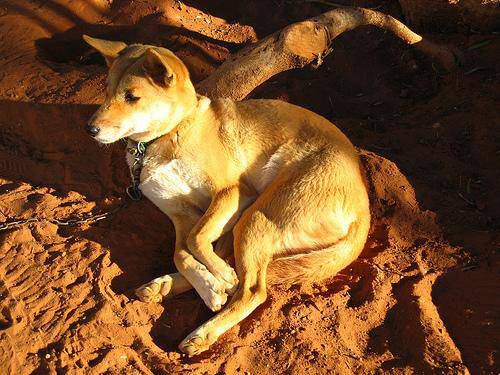

In [19]:
img = PIL.Image.open(fn); img

In [20]:
img.size

(500, 375)

- Now we check image size. If they are huge, then you have to think really carefully about how to deal with them. If they are tiny, it is also challenging. Most of ImageNet models are trained on either 224 by 224 or 299 by 299 images

In [ ]:
size_d = {k: PIL.Image.open(PATH+k).size for k in data.trn_ds.fnames}

In [ ]:
row_sz, col_sz = list(zip(*size_d.values()))

In [ ]:
row_sz = np.array(row_sz); col_sz = np.array(col_sz)

In [24]:
row_sz[:5]

array([500, 500, 500, 500, 500])

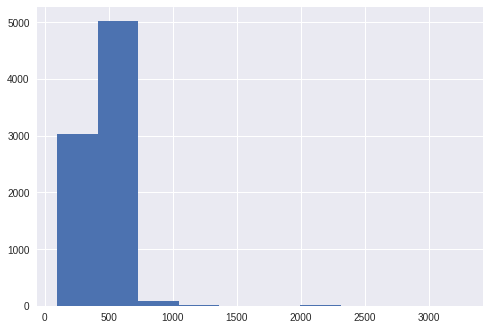

In [25]:
plt.hist(row_sz);

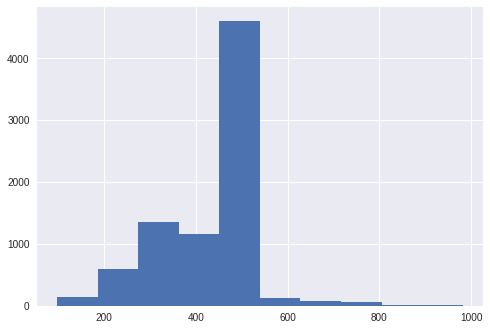

In [26]:
plt.hist(row_sz[row_sz<1000]);

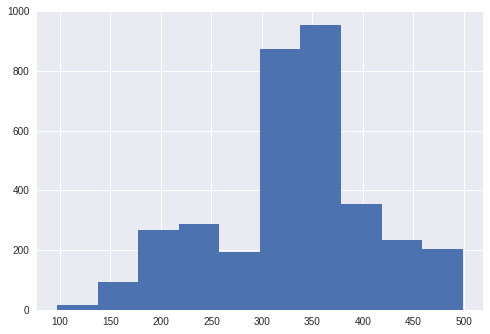

In [27]:
plt.hist(row_sz[row_sz<500]);

In [ ]:
def get_data(sz, bs):
  tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
  data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv', test_name='test',
                                      num_workers=4, val_idxs=val_idxs, suffix='.jpg', tfms=tfms, bs=bs)
  return data if sz > 300 else data.resize(340, 'tmp')

In [29]:
data = get_data(sz, bs)

In [42]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

100%|██████████| 648/648 [06:17<00:00,  2.12it/s]


In [43]:
learn.fit(1e-2, 5, cycle_len=1)

epoch      trn_loss   val_loss   accuracy   
    0      0.63264    0.325359   0.906067  
    1      0.454795   0.282478   0.911448  
    2      0.304221   0.257738   0.917319  
    3      0.248162   0.272815   0.912916  
    4      0.265861   0.265341   0.921722  



[array([0.26534]), 0.9217221135029354]

In [ ]:
learn.precompute = False

In [ ]:
learn.fit(1e-2, 5, cycle_len=1)

In [ ]:
learn.save('224_pre')
learn.load('224_pre')

- Increase image size

In [45]:
learn.set_data(get_data(299, bs))

In [47]:
learn.fit(1e-2, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy   
    0      0.248789   0.271804   0.914873  
    1      0.196516   0.274877   0.91683   
    2      0.232653   0.265154   0.914384  



[array([0.26515]), 0.9143835616438356]

In [48]:
learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy   
    0      0.144993   0.257192   0.919276  
    1      0.165479   0.269529   0.914873  
    2      0.104352   0.271516   0.919765  
    3      0.193465   0.28891    0.914873  
    4      0.110562   0.296159   0.912427  
    5      0.081249   0.268119   0.915362  
    6      0.073484   0.26705    0.922211  



[array([0.26705]), 0.9222113502935421]

In [ ]:
def accuracy_np(preds, targs):
  preds = np.argmax(preds, 1)
  return (preds==targs).mean()

In [53]:
log_preds, y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y), metrics.log_loss(y, probs)

(0.9222113502935421, 0.26748374853036955)

In [ ]:
learn.save('229_pre')
learn.load('229_pre')

In [55]:
learn.fit(1e-2, 1, cycle_len=2)

epoch      trn_loss   val_loss   accuracy   
    0      0.095224   0.286177   0.913405  
    1      0.081667   0.266867   0.924168  



[array([0.26687]), 0.9241682974559687]

In [ ]:
learn.save('299_pre')

In [57]:
log_preds, y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y), metrics.log_loss(y, probs)

(0.9241682974559687, 0.2670850706397466)

#### Other things to try:

- Try running one more cycle of 2 epochs
- Unfreezing (in this case, training convolutional layers did not help in the slightest since the images actually came from ImageNet)
- Remove validation set and just re-run the same steps, and submit that — which lets us use 100% of the data.

##### Difference between precompute=True and unfreeze?

- We started with a pre-trained network
- We added a couple of layers on the end of it which start out random. With everything frozen and precompute=True, all we are learning is the layers we have added.
- With precompute=True, data augmentation does not do anything because we are showing exactly the same activations each time.
- We then set precompute=False which means we are still only training the layers we added because it is frozen but data augmentation is now working because it is actually going through and recalculating all of the activations from scratch.
- Then finally, we unfreeze which is saying “okay, now you can go ahead and change all of these earlier convolutional filters”.

### Minimal steps to get good results:

1. Use lr_find() to find highest learning rate where loss is still clearly improving
2. Train last layer with data augmentation (i.e. precompute=False) for 2–3 epochs with cycle_len=1
3. Unfreeze all layers
4. Set earlier layers to 3x-10x lower learning rate than next higher layer
5. Train full network with cycle_mult=2 until over-fitting